# ETAPE 1: PREPARATION DES DONNEES


*****

# Contents:
* Telechargement des librairies nécessaires
* Récupération des données
* Description des données
    * Base d'apprentissage
    * Base de test
    * Base ressources
* Nettoyage des données
    * Construction du dataset de travail
* Visualisation des données
    * Quel genre de professeur propose le plus de projets ?
    * Dans quel état propose-t-on le plus de projets ?
    * Comment évoluent les propositions de projets dans le temps ?
    * Pour quelles classes a-t-on le plus de propositions de projets ?
    * Sur quelles catégories de projets a-t-on le plus de propositions ?
    * Text features
* Features engineering
    * Full data set
    * Base de ressources
    * Jointure de la base 'apprentissage + test' à la nouvelle base 'ressources'
    * Text engineering
* Liens entre les variables
    * Etude de la variable cible
    * Etude du taux d'approbation des projets
    * Etude du prix des projets
* Apprentissage

## 1. Telechargement des librairies nécessaires
*****

In [1]:
# Si les librairies ne sont pas installées : 
# conda install -c conda-forge wordcloud=1.2.1

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
import re
import nltk
from wordcloud import WordCloud, STOPWORDS

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.metrics import roc_curve

## 2. Récupération des données
*****

On import les données sous forme de DataFrames Pandas

In [2]:
#La fonction read_csv de la librairie Pandas renvoi par défaut un dataframe
#On précise lors de l'import que l'index des deux tables est la colonne 'id' representant l'identifiant du projet

train_df = pd.read_csv('../input/train.csv', index_col='id')
test_df  = pd.read_csv('../input/test.csv', sep=',', dtype='unicode', index_col='id')
res = pd.read_csv('../input/resources.csv', index_col='id')

In [3]:
type(train_df)

pandas.core.frame.DataFrame

In [4]:
# On affiche les 3 premières lignes du Dataframe pour avoir une vision plus claire des données 
train_df.head(3)

,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
id,,,,,,,,,,,,,,,
p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1


## 3. Description des données
*****

### 3.1. Base d'apprentissage

In [5]:
print('Liste des variables: \n',train_df.columns.values,'\n')
print('Nb variables : ',train_df.shape[1])
print('Nb observations : ',train_df.shape[0])

Liste des variables: 
 ['teacher_id' 'teacher_prefix' 'school_state' 'project_submitted_datetime'
 'project_grade_category' 'project_subject_categories'
 'project_subject_subcategories' 'project_title' 'project_essay_1'
 'project_essay_2' 'project_essay_3' 'project_essay_4'
 'project_resource_summary' 'teacher_number_of_previously_posted_projects'
 'project_is_approved'] 

Nb variables :  15
Nb observations :  182080


On affiche l'enssemble des informations concernant les attributs (types, nullable, etc)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182080 entries, p036502 to p190772
Data columns (total 15 columns):
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                                 6374 non-null object
project_resource_summary               

On ajoute l'option (include = "all") pour afficher la description de toutes les variables. 

In [7]:
train_df.describe(include = "all")

,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
count,182080,182076,182080,182080,182080,182080,182080,182080,182080,182080,6374,6374,182080,182080.000000,182080.000000
unique,104414,5,51,180439,4,51,407,164282,147689,180984,6359,6336,179730,NaN,NaN
top,fa2f220b537e8653fb48878ebb38044d,Mrs.,CA,2016-09-01 00:00:03,Grades PreK-2,Literacy & Language,Literacy,Flexible Seating,As a teacher in a low-income/high poverty scho...,Students will be using Chromebooks to increase...,Baritone ukuleles are an engaging way for stud...,"Having taught engineering in college, I have c...",My students need electronic tablets to do all ...,NaN,NaN
freq,74,95405,25695,30,73890,39257,15775,377,46,24,2,3,84,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.237055,0.847682
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.016086,0.359330
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,1.000000


Nous disposons de 182080 observations dans notre base d'apprentissage.

Une analyse de nos données nous permet de résumé les informations suivantes:
- 104414 enseignants ont soumi des candidatures
- Les identités de l'enseignant et de l'ecole sont anonymes: nous n'avons à disposition que l'id, le genre (teacher_prefix) et l'état de l'ecole pour laquelle l'enseignant fait la demande.
- Ces candidatures proviennent de 51 états américains différents
- Il existe 51 catégories de projets subdivisées en 407 sous-catégories
- Certains projets portent le même nom (car sur 182080 projets, nous observons 147689 noms de projets différents).
- De même que certains projets ont les mêmes descriptions (variables project_essay_1 et project_essay_2), ce qui peut se justifier de deux manières: 
    *soit ces projets ont été proposés avant le 17 mai 2016 pour une même classe (car avant cette date, les variables project_essay_1 et project_essay_2 devaient répondre respectivement aux questions: « Présentez - nous votre salle de classe » et « Donnez nous plus d'informations sur vos étudiants »).
    *soit notre table comprend des doublons, ce qui est probable car on peut faire la même remarque pour les variables project_essay_3 et project_essay_4 (dont les contenus ne sont pas forcément uniques car les textes dans ces champs correspondent respectivement aux réponses aux questions « Décrivez comment vos élèves utiliseront les matériaux que vous demandez » et « Pourquoi votre projet fera une différence »). Dans ce cas, il faudra les supprimés lors de la phase de nettoyage des données.
- Pour finir, nous avons l'information concernant le nombre de projets que l'enseignant a soumis avant celui-ci. Il est dommage toutefois de ne pas avoir l'information sur le nombre de ceux qui ont été approuvés. Nous essayerons de voir dans la suite du projet s'il est possible, à partir des informations dont on dispose, de retrouver cette donnée.

On dispose dans notre dataset de 15 variables.

- 6 variables catégorielles (ou qualitatives) :
     * Nominales : 'teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories',   'project_subject_subcategories'
     * Ordinales : 'project_submitted_datetime' 

- 3 variables quantitatives :
     * Discrètes : 'teacher_id', 'teacher_number_of_previously_posted_projects', 'project_is_approved', 
      (AJOUTER SI CORRECTE : 'id' (identifiant du projet))

- Et 6 variables de type 'texte libre' :
     * 'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4',    'project_resource_summary'

Il est important de bien analyser le type de variable car cela va nous permettre de mieux déterminer le type de graphique pour les représenter plus tard (le type de graphique a utilisé differe en fonction du type des variables).

Dans ce jeu de données, la variable cible (variable à predire) est la variable 'project_is_approved'.

Pour ce qui est du type de données, nous avons:
- 2 variables de type int, 1 pour les données test car on y retrouve pas la variable cible 'project_is_approved'
- 1 variable de type datetime (qui est encodée en type object mais que nous allons mettre en forme dans la suite du programme)
- 13 variables de type string (object)

On remarque la presence de données manquantes pour les variables 'project_essay_3' et 'project_essay_4' nous avons 6374 occurrences au lieu de 182080.
Cela est certainement dû au fait qu'à partir du 17 mai 2016, le nombre d'essais a été réduit de 4 à 2. 
Il faudra tout de même verifier/confirmer cette information puis s'occuper de ces données lors de la phase de nettoyage.

***
On convertit à présent le type du champ project_submitted_datetime en type datetime pour être cohérents sur nos types de données.<br>
Ensuite, on effectue un affichage pour vérifier que notre conversion a bien marché.

In [8]:
train_df["project_submitted_datetime"] = pd.to_datetime(train_df["project_submitted_datetime"]) 
train_df.dtypes

teacher_id                                              object
teacher_prefix                                          object
school_state                                            object
project_submitted_datetime                      datetime64[ns]
project_grade_category                                  object
project_subject_categories                              object
project_subject_subcategories                           object
project_title                                           object
project_essay_1                                         object
project_essay_2                                         object
project_essay_3                                         object
project_essay_4                                         object
project_resource_summary                                object
teacher_number_of_previously_posted_projects             int64
project_is_approved                                      int64
dtype: object

### 3.2. Base de test

In [9]:
print('Liste des variables: \n',test_df.columns.values,'\n')
print('Nb variables : ',test_df.shape[1])
print('Nb observations : ',test_df.shape[0])

Liste des variables: 
 ['teacher_id' 'teacher_prefix' 'school_state' 'project_submitted_datetime'
 'project_grade_category' 'project_subject_categories'
 'project_subject_subcategories' 'project_title' 'project_essay_1'
 'project_essay_2' 'project_essay_3' 'project_essay_4'
 'project_resource_summary' 'teacher_number_of_previously_posted_projects'] 

Nb variables :  14
Nb observations :  78035


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78035 entries, p233245 to p087783
Data columns (total 14 columns):
teacher_id                                      78035 non-null object
teacher_prefix                                  78034 non-null object
school_state                                    78035 non-null object
project_submitted_datetime                      78035 non-null object
project_grade_category                          78035 non-null object
project_subject_categories                      78035 non-null object
project_subject_subcategories                   78035 non-null object
project_title                                   78035 non-null object
project_essay_1                                 78035 non-null object
project_essay_2                                 78035 non-null object
project_essay_3                                 2704 non-null object
project_essay_4                                 2704 non-null object
project_resource_summary                        78

Nous disposons de 78035 observations dans notre base de test.

Les données de test ont bien sûr les mêmes caractéristiques et le même format que les données d'apprentissage, moins les caractéristiques des données cibles, naturellement (ici, la donnée 'project_is_approved'). 
Nous allons donc procéder à la conversion des variables dans les bons formats.

***
On convertit le type du champ <b>project_submitted_datetime</b> en type datetime. <br>
Ensuite, on effectue une conversion sur le champ <b>teacher_number_of_previously_posted_projects</b> en int

Enfin, on affiche les données pour vérifier que notre conversion a bien marché

In [11]:
test_df["project_submitted_datetime"] = pd.to_datetime(test_df["project_submitted_datetime"])
test_df["teacher_number_of_previously_posted_projects"] = test_df["teacher_number_of_previously_posted_projects"].astype(int)

test_df.dtypes

teacher_id                                              object
teacher_prefix                                          object
school_state                                            object
project_submitted_datetime                      datetime64[ns]
project_grade_category                                  object
project_subject_categories                              object
project_subject_subcategories                           object
project_title                                           object
project_essay_1                                         object
project_essay_2                                         object
project_essay_3                                         object
project_essay_4                                         object
project_resource_summary                                object
teacher_number_of_previously_posted_projects             int64
dtype: object

### 3.3. Base ressources

On affiche à présent les données liées aux ressources.

In [12]:
res.head(5)

,description,quantity,price
id,,,
p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [13]:
print('Liste des variables: \n',res.columns.values,'\n')
print('Nb variables : ',res.shape[1])
print('Nb observations : ',res.shape[0])

Liste des variables: 
 ['description' 'quantity' 'price'] 

Nb variables :  3
Nb observations :  1541272


In [14]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541272 entries, p233245 to p031981
Data columns (total 3 columns):
description    1540980 non-null object
quantity       1541272 non-null int64
price          1541272 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 47.0+ MB


In [15]:
res.isnull().sum()

description    292
quantity         0
price            0
dtype: int64

On remarque que certaines ressources demandées (exactement 292 ressources) n'ont pas de description.

***
On convertit le champs description en champs de type 'chaine de caratères'.

Les champs nuls seront remplacer par des champs vides

In [16]:
res['description'] = res['description'].astype(str)

In [17]:
idsUnique = len(res.index.unique())
print('Nbr idUnique = ', idsUnique)

idsTotal = len(res.index)
print('Nbr idTotal = ', idsTotal)

Nbr idUnique =  260115
Nbr idTotal =  1541272


Nous remarquons qu'au niveau de la data frame 'ressources', les ids sont dupliqués.<br>
On peut donc avoir une demande de plusieures ressources pour un seul projet.

## 4. Nettoyage des données
*****

### Construction du dataset de travail

On commence par associer les deux data set apprentissage et test afin d'effectuer nos opération de nettoyage de données librement. <br>
Pour cela on doit d'abord rajouter une variable de type boolean qui nous permettera de differencier les données d'apprentissage des données de test.

In [18]:
train_df['is_train'] = 1
test_df['is_train'] = 0

In [19]:
# on concatene les deux data set
df = pd.concat([train_df, test_df])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [20]:
# nombre de ligne du data set d'apprentissage
print("Apprentissage : ", train_df.shape)

# nombre de ligne du data set de test
print("Test          : ", test_df.shape)

# nombre de ligne du data set du model
print("Full data set : " ,df.shape)

Apprentissage :  (182080, 16)
Test          :  (78035, 15)
Full data set :  (260115, 16)


In [21]:
test_df.shape[0]/df.shape[0]

0.3000019222267074

Notre base de test represente 30% de la base complete.

In [22]:
df.dtypes

is_train                                                 int64
project_essay_1                                         object
project_essay_2                                         object
project_essay_3                                         object
project_essay_4                                         object
project_grade_category                                  object
project_is_approved                                    float64
project_resource_summary                                object
project_subject_categories                              object
project_subject_subcategories                           object
project_submitted_datetime                      datetime64[ns]
project_title                                           object
school_state                                            object
teacher_id                                              object
teacher_number_of_previously_posted_projects             int64
teacher_prefix                                         

On affiche le nombre de valeurs manquantes pour chaque variable

In [23]:
df.isnull().sum()

is_train                                             0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 251037
project_essay_4                                 251037
project_grade_category                               0
project_is_approved                              78035
project_resource_summary                             0
project_subject_categories                           0
project_subject_subcategories                        0
project_submitted_datetime                           0
project_title                                        0
school_state                                         0
teacher_id                                           0
teacher_number_of_previously_posted_projects         0
teacher_prefix                                       5
dtype: int64

On remarque qu'il manque l'information sur le prefixe de 5 professeurs.<br>
On remarque également que le nombre d'informations manquantes pour les variables 'project_essay_3' et 'project_essay_4' est 251037.<br>
Nous allons essayer de voir si ces champs sont vides à cause de la réduction du nombre d'essais à partir du 17 mai 2016.<br>

Les 78035 données manquantes pour le champs 'project_is_approved' correspondent aux données de la base de test.

In [24]:
# On fait une selection de tous les projets soumis après le 17 mai 2016
t = df[df['project_submitted_datetime'] < '2016-05-17 00:00:00']
t.isnull().sum()

is_train                                           0
project_essay_1                                    0
project_essay_2                                    0
project_essay_3                                    0
project_essay_4                                    0
project_grade_category                             0
project_is_approved                             2696
project_resource_summary                           0
project_subject_categories                         0
project_subject_subcategories                      0
project_submitted_datetime                         0
project_title                                      0
school_state                                       0
teacher_id                                         0
teacher_number_of_previously_posted_projects       0
teacher_prefix                                     2
dtype: int64

On remarque qu'il n'y a pas de données manquantes pour les champs project_essay_1, project_essay_2, project_essay_3 et project_essay_4 avant le 17 mai 2016.<br>
Nous tenteront de vérifier les variables project_essay_1 et project_essay_2 aprés cette date.

In [25]:
# On fait cette fois une selection de tous les projets soumis après le 17 mai 2016 à 10h

t = df[df['project_submitted_datetime'] > '2016-05-17 10:00:00']
t.isnull().sum()

is_train                                             0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 251037
project_essay_4                                 251037
project_grade_category                               0
project_is_approved                              75331
project_resource_summary                             0
project_subject_categories                           0
project_subject_subcategories                        0
project_submitted_datetime                           0
project_title                                        0
school_state                                         0
teacher_id                                           0
teacher_number_of_previously_posted_projects         0
teacher_prefix                                       3
dtype: int64

On retrouve bien maintenant le nombre de données manquantes (251037) au niveau des variables : project_essay_3 et project_essay_4. <br>
Nous remarquons également l'absence de données manquantes au niveau des variables project_essay_1 et project_essay_2. <br>

++ 3 valeurs manquantes se trouvent aprés le 17 mai 2017 et 2 valeurs manquantes avant cette date pour la variable teacher_prefix <br>

In [26]:
df.teacher_prefix.value_counts()

Mrs.       136387
Ms.         92651
Mr.         25462
Teacher      5569
Dr.            41
Name: teacher_prefix, dtype: int64

## 5. Visualisation des données
*****

### 5.1. Quel genre de professeur propose le plus de projets ?

On affiche le nombre de professeur de chaque genre

In [27]:
df['teacher_prefix'].value_counts()

Mrs.       136387
Ms.         92651
Mr.         25462
Teacher      5569
Dr.            41
Name: teacher_prefix, dtype: int64

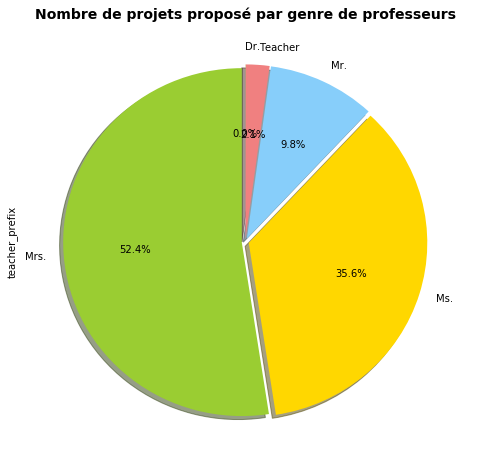

In [28]:
plt.figure(figsize=(8,8))
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
explode = (0.02, 0.02, 0.02, 0.02, 0.02) 

df['teacher_prefix'].value_counts().plot.pie(explode = explode, colors = colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Nombre de projets proposé par genre de professeurs', fontsize=14, fontweight="bold")
plt.show()

Les femmes professeurs (de prefixes Mrs. et Ms.) proposent plus de projets que les hommes professeurs (de prefixe Mr.).<br> 
Les 2 autres prefixes Teacher et Dr. sont neutres, on ne peut pas dire s'il s'agit d'une femme ou d'un homme.<br>
On base donc nos constatations sur les données que l'on peut catégoriser.<br> 
(Cela étant dit, même si ces 2 prefixes correspondent à des professeurs hommes, nos résultats résteraient identiques).<br>

On constate que le nombre de 'Dr' est si faible qu'en moyenne sur le diagramme celui ci represente 0%.

#### Nombre moyen de propositions par professeurs

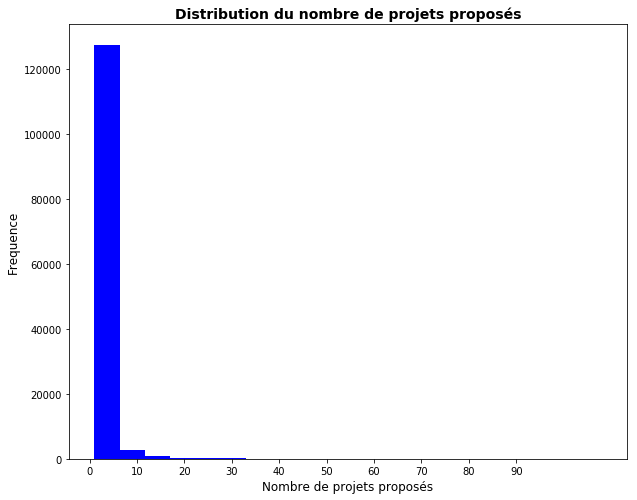

In [29]:
plt.figure(figsize=(10,8))
plt.hist(df['teacher_id'].value_counts(), bins=20, color='blue')
plt.xticks(range(0, 100, 10))
plt.title('Distribution du nombre de projets proposés', fontsize=14, fontweight="bold")
plt.xlabel("Nombre de projets proposés", fontsize=12)
plt.ylabel("Frequence", fontsize=12)
plt.show()

Un nombre considérable de professeurs ont soumis plus d'1 proposition.<br>
Plus de 120000 professeurs ont soumis entre 1 et 10 propositions.

#### Nombre moyen de précédentes propositions par professeurs

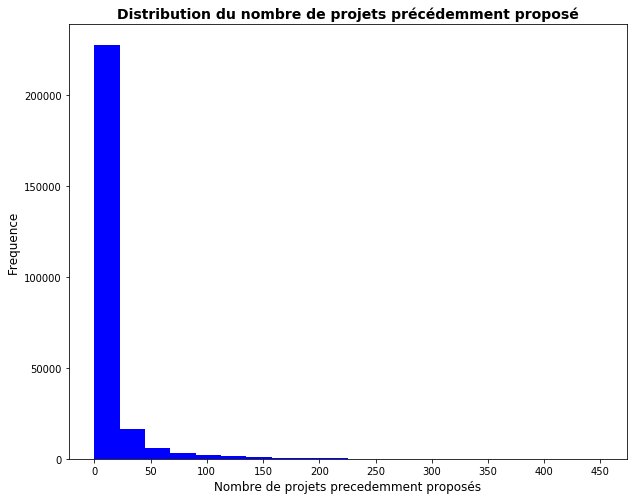

In [30]:
plt.figure(figsize=(10,8))
plt.hist(df['teacher_number_of_previously_posted_projects'], bins=20, color='blue')
plt.xticks(range(0, 500, 50))
plt.title('Distribution du nombre de projets précédemment proposé', fontsize=14, fontweight="bold")
plt.xlabel("Nombre de projets precedemment proposés", fontsize=12)
plt.ylabel("Frequence", fontsize=12)
plt.show()

On constate que la majorité des professeurs avaient déjà soumis des demandes de projets dans le passé. <br>
Il serait intéréssant de voir si le fait d'avoir déjà fait une proposition, d'avoir de l'experience, améliore les chances que le projets soit selectionner.<br>
Nous allons tenter de vérifier cela au cours de notre analyse.<br>

### 5.2. Dans quel état propose-t-on le plus de projets ?

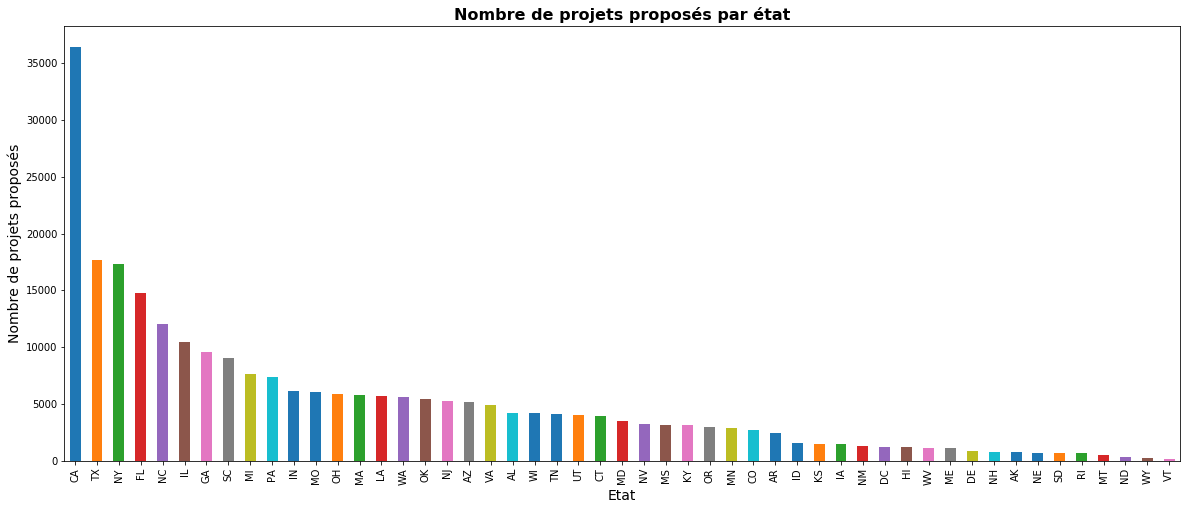

In [31]:
plt.figure(figsize=(20,8))
df['school_state'].value_counts().plot.bar()
plt.title('Nombre de projets proposés par état', fontsize=16, fontweight="bold")
plt.xlabel('Etat', fontsize=14)
plt.ylabel('Nombre de projets proposés', fontsize=14)
plt.show()

In [32]:
sum(df['school_state'].value_counts().head(10))/sum(df['school_state'].value_counts())

0.5475462776079811

On remarque que les 10 premiers états propose déjà plus de 50% des projets.<br>
On affiche alors à nouveau l'histogramme précédent en gardant cette fois-ci uniquement les 10 premiers états.

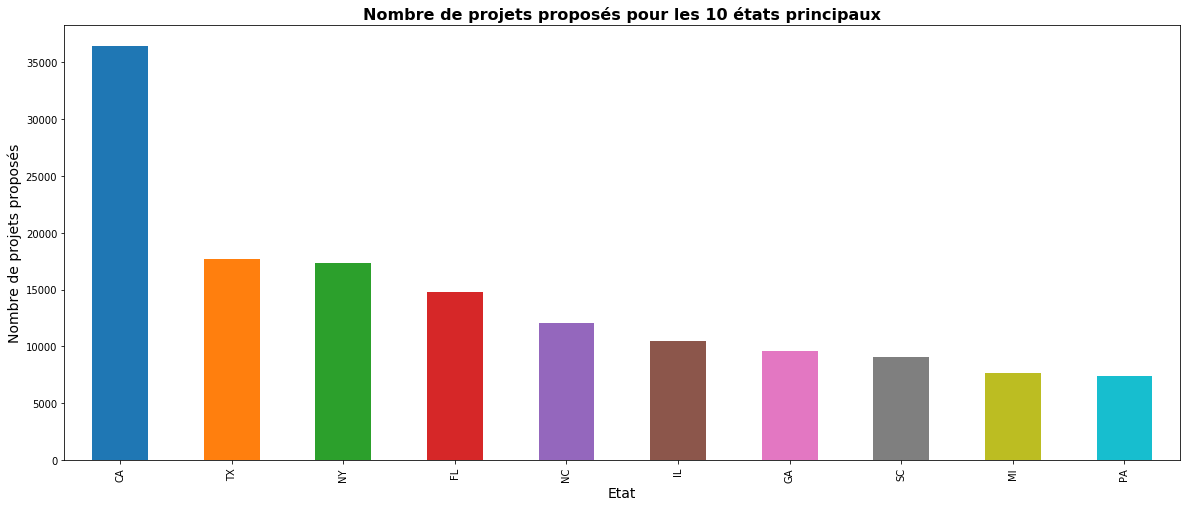

In [33]:
plt.figure(figsize=(20,8))
df['school_state'].value_counts().head(10).plot.bar()
plt.title('Nombre de projets proposés pour les 10 états principaux', fontsize=16, fontweight="bold")
plt.xlabel('Etat', fontsize=14)
plt.ylabel('Nombre de projets proposés', fontsize=14)
plt.show()

Les 3 états qui proposent le plus de projets sont respectivement: la Californie, le Texas puis New York.

Cependant, cela peut se justifier si le nombre d'écoles dans ces états ou le nombre de professeurs s'y trouvant est beaucoup plus grand que dans les autres.<br>
Il s'agit en fait d'un 'classement' qui ne prend pas en compte ces 2 facteurs.

### 5.3. Comment évoluent les propositions de projets dans le temps ?

Tout d'abord on crée de nouvelles variables nous permettant de récupérer respectivement la date, le mois, le jour de la semaine et l'année pour chaque proposition de projets.

On crée maintenant les variables extraitent du champ project_submitted_datetime

Year of Submission : Valeur de l'année où la proposition a été soumise<br>
Month of Submission : numéro du mois (valeurs comprises entre 1 et 12) lorsque la proposition a été soumise<br>
Week Day of Submission : valeur de la semaine (valeurs comprises entre 1 et 7) lorsque la proposition a été soumise<br>
Hour of Submission : Valeur de l'heure (valeurs entre 0 et 23) lorsque la proposition a été soumise<br>
Day of Submission : le jour de l'année correspondant à une soumission

In [34]:
df["date"] = df.project_submitted_datetime.apply( lambda x: x.date() )
df["year"] = df.project_submitted_datetime.apply( lambda x: x.year )
df["month"] = df.project_submitted_datetime.apply( lambda x: x.month )
df["weekday"] = df["project_submitted_datetime"].dt.weekday
df["hour"] = df["project_submitted_datetime"].dt.hour
df["day"] = df["project_submitted_datetime"].dt.day

In [35]:
nbr_projets_date = df[["date","project_is_approved"]].groupby("date").count()

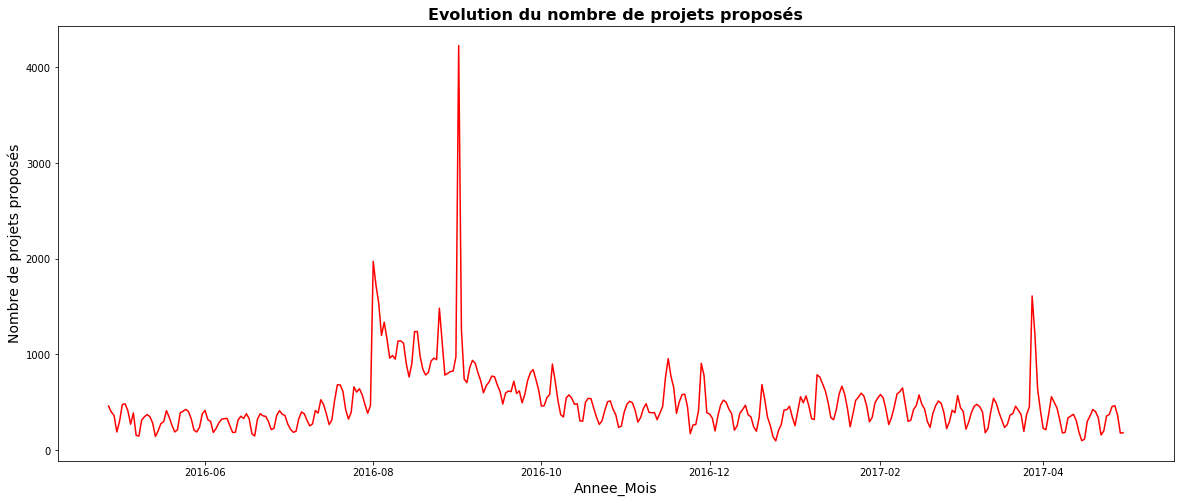

In [36]:
plt.figure(figsize=(20,8))
plt.plot(nbr_projets_date,"red")
plt.title('Evolution du nombre de projets proposés', fontsize=16, fontweight="bold")
plt.xlabel('Annee_Mois', fontsize=14)
plt.ylabel('Nombre de projets proposés', fontsize=14)
plt.show()

On remarque que la base d'apprentissage contient environ 1 an d'historique, d'Avril 2016 à Avril 2017.<br>
On remarque également que le nombre de propositions augmente entre Aout et Septembre 2016. <br>
Afin d'affiner cette constatation nous allons afficher la distribution du nombre de projets par mois. 

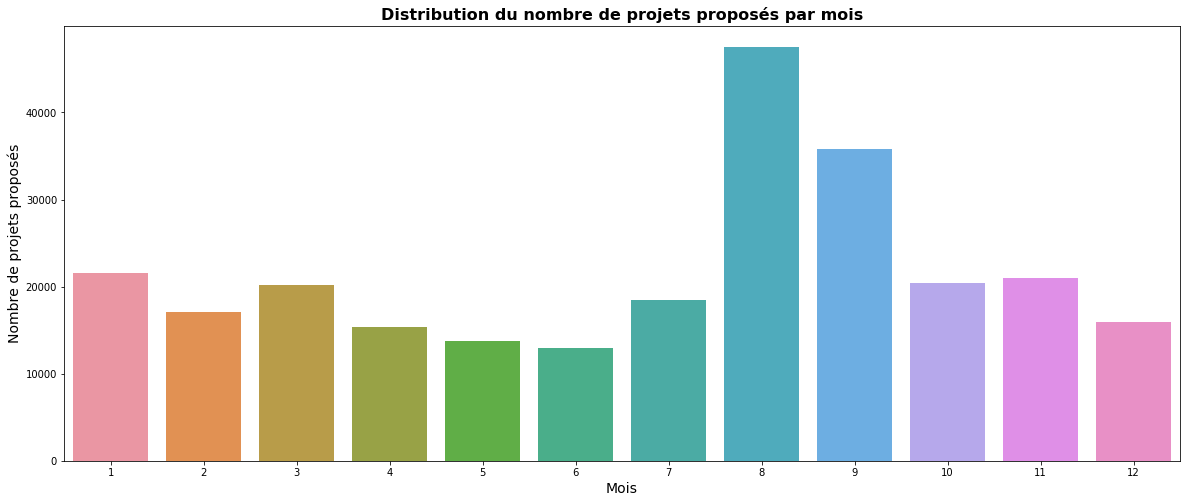

In [37]:
plt.figure(figsize=(20,8))
sns.countplot(x='month', data=df)
plt.title('Distribution du nombre de projets proposés par mois', fontsize=16, fontweight="bold")
plt.xlabel('Mois', fontsize=14)
plt.ylabel('Nombre de projets proposés', fontsize=14)
plt.show()

Ce graphique confirme bien nos constations précédentes. <br>
On remarque que le nombre de propositions est particulièrement élevé aux mois d'Août et Septembre. Il s'agit de la période de rentrée scolaire, ce qui justifie ces résultats.<br>
De même on constate que le nombre de propositions est faible durant la période de fin d'année et de vacances scolaires (mois de Mai, Juin et Juillet).<br>

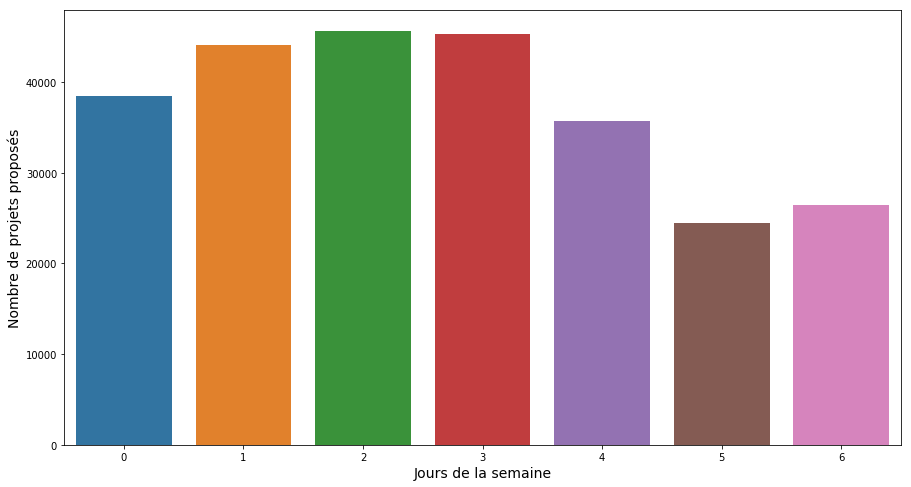

In [38]:
plt.figure(figsize=(15,8))
sns.countplot(x='weekday', data=df)
plt.xlabel('Jours de la semaine', fontsize=14)
plt.ylabel('Nombre de projets proposés', fontsize=14)
plt.show()

On remarque que les propositions sont faite le plus souvent les Mercredi et plus généralement en semaine et que ce nombre diminue en week-end.

### 5.4. Pour quelles classes a-t-on le plus de propositions de projets ? 

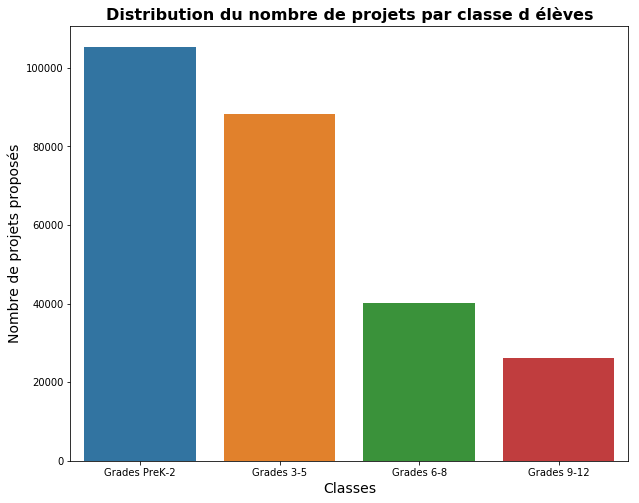

In [39]:
plt.figure(figsize=(10,8))
sns.countplot(x='project_grade_category', data=df)
plt.title('Distribution du nombre de projets par classe d élèves', fontsize=16, fontweight="bold")
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Nombre de projets proposés', fontsize=14)
plt.show()

On remarque que c'est pour les classes d'éléves les plus jeunes que nous avons le plus de propositions. <br>
Le nombre de propositions diminue de plus en plus pour les classes plus agées. 

### 5.5. Sur quelles catégories de projets a-t-on le plus de propositions ? 

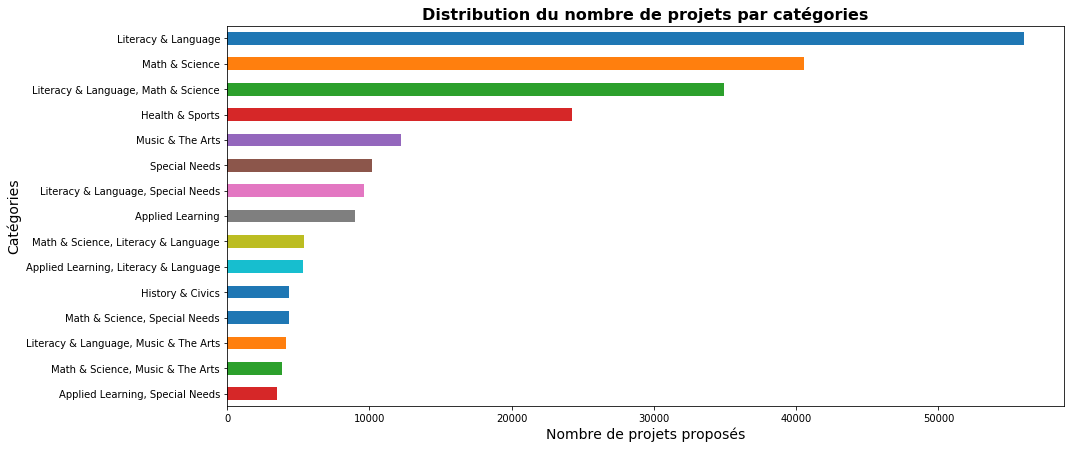

In [40]:
plt.figure(figsize=(15,7))
df['project_subject_categories'].value_counts().head(15).plot.barh().invert_yaxis()
plt.title('Distribution du nombre de projets par catégories', fontsize=16, fontweight="bold")
plt.ylabel('Catégories', fontsize=14)
plt.xlabel('Nombre de projets proposés', fontsize=14)
plt.show()

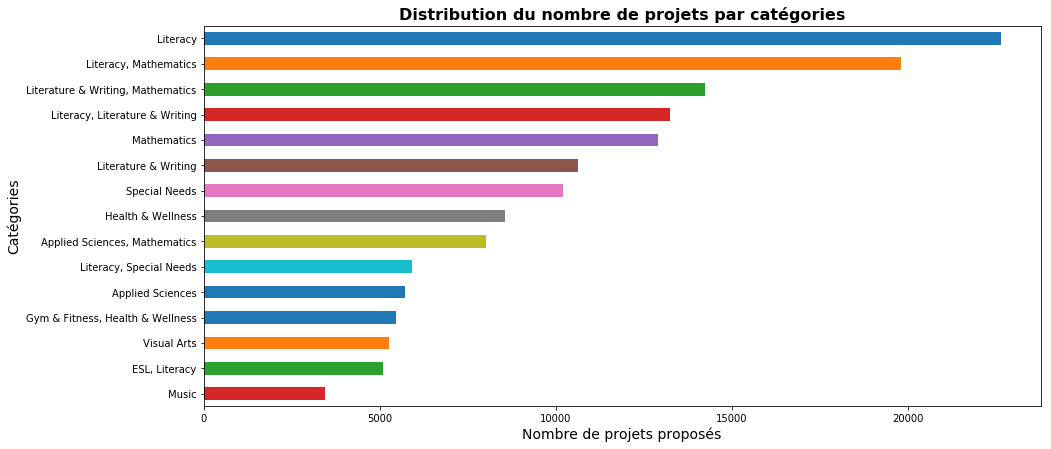

In [41]:
plt.figure(figsize=(15,7))
df['project_subject_subcategories'].value_counts().head(15).plot.barh().invert_yaxis()
plt.title('Distribution du nombre de projets par catégories', fontsize=16, fontweight="bold")
plt.ylabel('Catégories', fontsize=14)
plt.xlabel('Nombre de projets proposés', fontsize=14)
plt.show()

On remarque que les sujets de catégorie 'Literacy and Language' sont les plus populaires, suivis des sujets de catégorie 'Mathematics and Science' ainsi que des sujets regroupants ces deux domaines.<br>
'Special Needs' et 'Applied Learning' sont également des sujet importants.<br>
Enfin, on trouve dans le top 10 les sujets de catégories 'Health & Sports' et 'Music & Arts'.

### 5.6. Text features

In [42]:
df = df.reset_index()

In [43]:
df.head(3)

,id,is_train,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_grade_category,project_is_approved,project_resource_summary,project_subject_categories,...,school_state,teacher_id,teacher_number_of_previously_posted_projects,teacher_prefix,date,year,month,weekday,hour,day
0,p036502,1,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,Grades PreK-2,1.0,My students need 6 Ipod Nano's to create and d...,Literacy & Language,...,NV,484aaf11257089a66cfedc9461c6bd0a,26,Ms.,2016-11-18,2016,11,4,14,18
1,p039565,1,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,Grades 3-5,0.0,My students need matching shirts to wear for d...,"Music & The Arts, Health & Sports",...,GA,df72a3ba8089423fa8a94be88060f6ed,1,Mrs.,2017-04-26,2017,4,2,15,26
2,p233823,1,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,Grades 3-5,1.0,My students need the 3doodler. We are an SEM s...,"Math & Science, Literacy & Language",...,UT,a9b876a9252e08a55e3d894150f75ba3,5,Ms.,2017-01-01,2017,1,6,22,1


#### 5.6.1. Titre du projet

In [44]:
wordcloud_title = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=40, max_font_size=40
                     ).generate(str(df['project_title']))

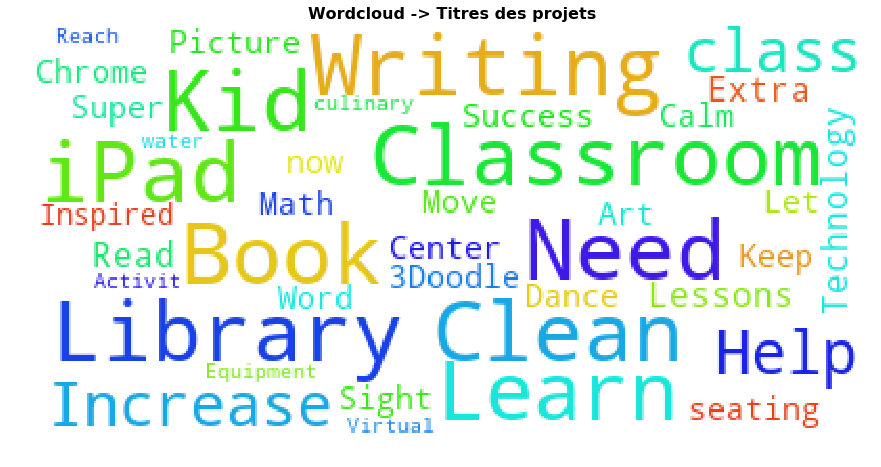

In [45]:
plt.figure(figsize=(15,8))
plt.title('Wordcloud -> Titres des projets', fontsize=16, fontweight="bold")
plt.axis('off')
plt.imshow(wordcloud_title)
plt.show()

On remarque que les mots qui reviennent le plus dans les titres sont : <br>
Kid, Need, Classroom, Clean, Writing, Learn, Book, Library, iPad

Plus tard nous chercherons à voir si le choix des mots dans le titre des projets a un effet sur l'approbation ou non du projet.

#### 5.6.2. Résumé des ressources nécéssaires

In [46]:
wordcloud_res = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=40, max_font_size=40
                     ).generate(str(df['project_resource_summary']))

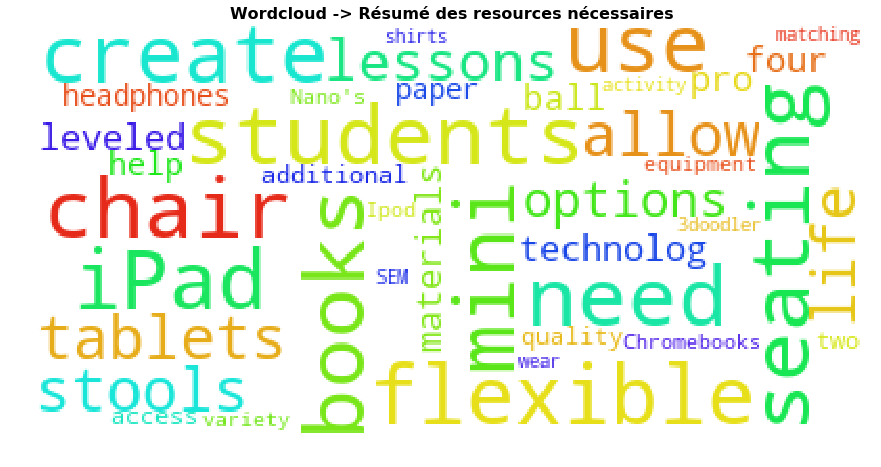

In [47]:
plt.figure(figsize=(15,8))
plt.title('Wordcloud -> Résumé des resources nécessaires', fontsize=16, fontweight="bold")
plt.axis('off')
plt.imshow(wordcloud_res)
plt.show()

Les mots les plus utilisés pour décrire les ressources demandées sont : <br>
iPad, books, seating, chair,  tablets, materials, flexible, quality <br>

D'autres mots sont également beaucoup utilisé (life, students, need par exemple) mais nous ne nous intéréssons qu'à ceux qui sont pértinents à l'analyse. <br>
Ces mots sont utilisés afin de convaincre de l'utiliter de la demande.

#### 5.6.3. Description de la classe

In [48]:
wordcloud_essay1 = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=100, max_font_size=40
                     ).generate(str(df['project_essay_1']))

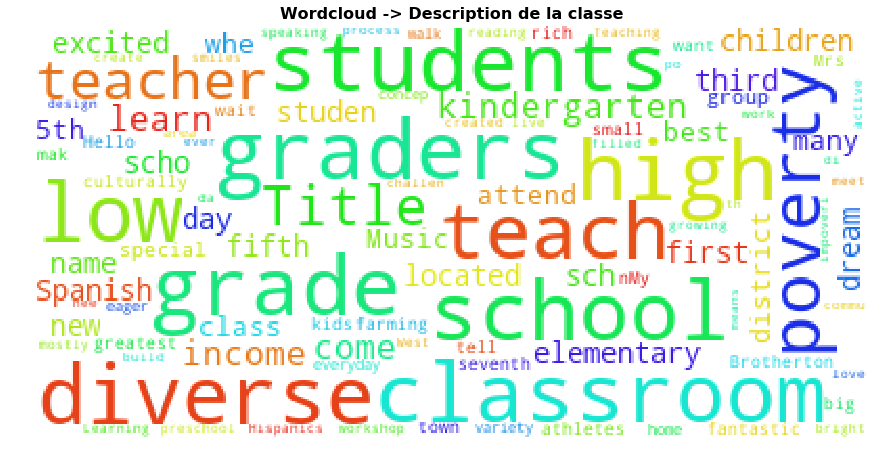

In [49]:
plt.figure(figsize=(15,8))
plt.title('Wordcloud -> Description de la classe', fontsize=16, fontweight="bold")
plt.axis('off')
plt.imshow(wordcloud_essay1)
plt.show()

Les mots les plus utilisés pour décrire les classes sont :<br>
students, classroom, school, high, low<br>
graders (niveau d'étude), diverse, elementary, children, kindergarten (jardin d'enfants) <br>

On retrouve également les mots : poverty (pauvreté), dream (rêve), located (qui peut vouloir dire restreint)<br>
Et les mots : greatest, bright, growing, excited, best, big 

#### 5.6.4. Description des étudiants

In [50]:
wordcloud_essay2 = WordCloud(background_color='white', stopwords=STOPWORDS, max_words=100, max_font_size=40
                     ).generate(str(df['project_essay_2']))

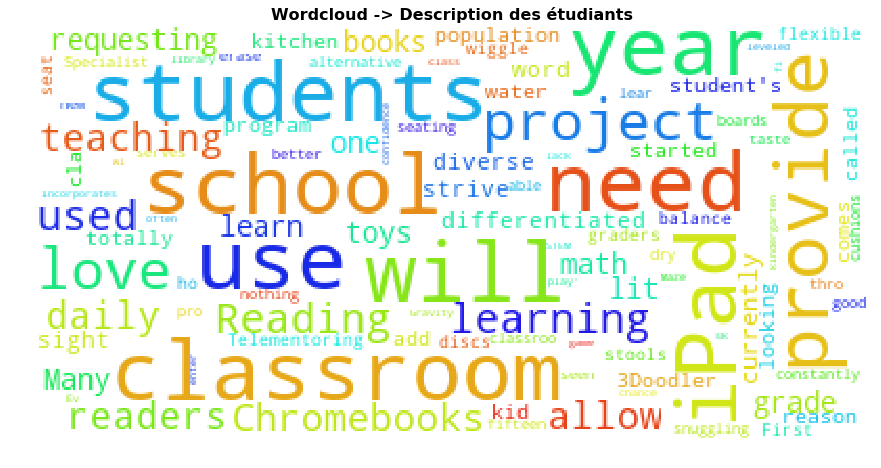

In [51]:
plt.figure(figsize=(15,8))
plt.title('Wordcloud -> Description des étudiants', fontsize=16, fontweight="bold")
plt.axis('off')
plt.imshow(wordcloud_essay2)
plt.show()

Les mots les plus utilisés pour décrire les étudiants sont :
students, classroom, school<br>
reading, need, learning, requesting, provide, allow, will, love, use, iPad, differentiated (faire la différence) <br>

##### Pour la description de l'utilisation qui sera faite des ressources demandées et les apports du projet (questions 3 et 4) nous n'avons pas assez de données pour faire la même analyse que précédemment. 
En lisant quelques essays on remarque la présence fréquente des mots workshop, lesson et reading pour la description de l'utilisation des ressources et les mots donation et blessing pour la question sur les apports du projet.

## 6. Features engineering
*****

### 6.1. Full data set

Ajout de nouvelles features<br>
On crée un champ 'Gender' qui nous donnera le sexe du professeur

In [52]:
gender_mapping = {"Ms.": "Female", "Mrs.":"Female", "Mr.":"Male", "Teacher":"Unknown", "Dr.":"Unknown", np.nan:"Unknown"  }
df["gender"] = df.teacher_prefix.map(gender_mapping)

### 6.2. Base de ressources

On peut extraire certaines caractéristiques de la base de ressources et les inclure à la base app+test. <br>
On calcul le coup total des ressources demandées pour chaque projet

In [53]:
res['total_cost'] = res['quantity'] * res['price']

In [54]:
res.head(3)

,description,quantity,price,total_cost
id,,,,
p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00,149.00
p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95,44.85
p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45,8.45


On concatene la description des ressources demandées pour chaque projet

In [55]:
res_descriptions = res.groupby('id')['description'].apply(lambda des: "%s" % ', '.join(des))
res_descriptions.head(5)

id
p000001    Cap Barbell 300 Pound Olympic Set, Grey, Cap B...
p000002    10 Sony Headphones (BUY 9 GET 1 FREE), Belkin ...
p000003    EE820X - Phonemic Awareness Instant Learning C...
p000004    A Bad Case of the Giggles Poems That Will Make...
p000005    Fitbit Zip Wireless Activity Tracker, Lime, Fi...
Name: description, dtype: object

On obtient ainsi un data frame avec 1 seule ligne pour chaque projet, contenant toutes les informations sur les ressources demandées.

On crée un nouveau data frame contenant 1 projet par ligne.

On aggrége pour cela: <br>
1.Les quantités<br>
-> en faisant d'une part une somme pour avoir le nombre de ressources demandées<br>
-> en faisant d'autre part un count pour avoir le nombre de ressources UNIQUES demandées<br>

2.Le prix individuel des ressources, en faisant une moyenne<br>
3.Le coup total des ressources demandées pour le projet, en faisant une somme<br>

In [56]:
res_df2 = res.groupby('id')['quantity','price','total_cost'].agg({'quantity':['sum','count'],'price':['mean'],'total_cost':['sum']})
res_df2.columns=['res_quantity_sum','unique_items','avg_price_per_item','total_cost']

On ajoute au nouveau data frame la descriptions des ressources demandées

In [57]:
res_df2['ressources_description'] = res_descriptions
res_df2 = res_df2.reset_index()

On peut calculer le nombre total de mots utilisés dans la description des ressources pour chaque projet

In [58]:
res_df2['desc_total_words'] = res_df2['ressources_description'].apply(lambda x: len(str(x).split()))

On peut également calculer le nombre total de mots UNIQUES utilisés dans la description des ressources

In [59]:
res_df2['count_unique_words'] = res_df2['ressources_description'].apply(lambda x: len(set(str(x).split())))

In [60]:
res_df2.head(3)

,id,res_quantity_sum,unique_items,avg_price_per_item,total_cost,ressources_description,desc_total_words,count_unique_words
0,p000001,7,4,114.890000,833.63,"Cap Barbell 300 Pound Olympic Set, Grey, Cap B...",31,28
1,p000002,21,14,36.849286,630.28,"10 Sony Headphones (BUY 9 GET 1 FREE), Belkin ...",130,94
2,p000003,4,4,74.742500,298.97,EE820X - Phonemic Awareness Instant Learning C...,30,24


### 6.3. Jointure de la base 'apprentissage + test' à la nouvelle base 'ressources'

In [61]:
df = pd.merge(df, res_df2, on='id')

On affiche à présent le résultat de la jointure

In [62]:
df.head(3)

,id,is_train,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_grade_category,project_is_approved,project_resource_summary,project_subject_categories,...,hour,day,gender,res_quantity_sum,unique_items,avg_price_per_item,total_cost,ressources_description,desc_total_words,count_unique_words
0,p036502,1,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,Grades PreK-2,1.0,My students need 6 Ipod Nano's to create and d...,Literacy & Language,...,14,18,Female,6,2,149.99,899.94,Apple - iPod nano� 16GB MP3 Player (8th Genera...,28,13
1,p039565,1,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,Grades 3-5,0.0,My students need matching shirts to wear for d...,"Music & The Arts, Health & Sports",...,15,26,Female,20,1,20.00,400.00,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,13,12
2,p233823,1,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,Grades 3-5,1.0,My students need the 3doodler. We are an SEM s...,"Math & Science, Literacy & Language",...,22,1,Female,1,1,469.99,469.99,3doodler Start Full Edu Bundle,5,5


Et aussi, les informations portant sur les attributs

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 260114
Data columns (total 31 columns):
id                                              260115 non-null object
is_train                                        260115 non-null int64
project_essay_1                                 260115 non-null object
project_essay_2                                 260115 non-null object
project_essay_3                                 9078 non-null object
project_essay_4                                 9078 non-null object
project_grade_category                          260115 non-null object
project_is_approved                             182080 non-null float64
project_resource_summary                        260115 non-null object
project_subject_categories                      260115 non-null object
project_subject_subcategories                   260115 non-null object
project_submitted_datetime                      260115 non-null datetime64[ns]
project_title                    

### 6.4. Text engineering

Nous allons à present effectuer un traitement afin de transformer les champs textuels en champs numériques et cela tout gardant la sémantique.

#### Project Essays:

Le 17 mai 2016, l'application DonorsChoose.org est passée de 4 invites d'essai à seulement 2 invites, donc à partir de ce moment, seuls <b>project_essay_1</b> et <b>project_essay_2</b> contiennent du texte, et <b>project_essay_3</b> et <b>project_essay_4</b> ont des comme valeur NaN.

Voici un résumé des messages d'essai avant et après cette date.

Avant le 17 mai 2016:

    project_essay_1: "Présentez-nous votre classe"
    project_essay_2: "Dites-nous en plus sur vos élèves"
    project_essay_3: "Décrivez comment vos élèves utiliseront les matériaux que vous demandez"
    project_essay_4: "Finissez en partageant pourquoi votre projet fera la différence"

Aprés le 17 mai 2016:

    project_essay_1: "Décrivez vos élèves: Qu'est-ce qui rend vos élèves spéciaux? Des détails précis sur leurs antécédents, votre quartier et votre école."
    project_essay_2: "À propos de votre projet: Comment ces matériaux vont-ils faire la différence dans l'apprentissage de vos élèves et améliorer leur vie scolaire?"

On effectuera les modifications suivante pour nettoyer les NaN:

    Nous Combinerons essay_1, essay_2 avant le 17 mai et également essay_1 après le 17 mai. Puis, nous stockerons le resultat dans la variable "student_description"
    Nous Combinerons essay_3, essay_4 avant le 17 mai et également essay_2 après le 17 mai. Puis, nous stockerons le resultat dans la variable "project_description"


Nous commençons par la variable <b>student_description</b>

In [64]:
df['student_description']=df['project_essay_1']

In [65]:
x=df[df.project_essay_3.notnull()]
print("La dernière fois qu'une entrée s'est produite dans l'essai du projet 3 -- ",x['project_submitted_datetime'].max())

La dernière fois qu'une entrée s'est produite dans l'essai du projet 3 --  2016-05-17 09:38:09


In [66]:
df.loc[df.project_essay_3.notnull(),'student_description']=df.loc[df.project_essay_3.notnull(),'project_essay_1']+df.loc[df.project_essay_3.notnull(),'project_essay_2']

Nous passons à présent à la variable <b>project_description</b>

In [67]:
df['project_description']=df['project_essay_2']

In [68]:
df.loc[df.project_essay_3.notnull(),'project_description']=df.loc[df.project_essay_3.notnull(),'project_essay_3']+df.loc[df.project_essay_3.notnull(),'project_essay_4']

Nous allons à présent supprimer les colonnes <b>project_essay_1</b>, <b>project_essay_2</b>, <b>project_essay_3</b> et <b>project_essay_4</b> car nous les avons déja traitées

In [69]:
del(df['project_essay_1'])
del(df['project_essay_2'])
del(df['project_essay_3'])
del(df['project_essay_4'])

Nous affichons à présent le résultat.

In [70]:
df.head(3)

,id,is_train,project_grade_category,project_is_approved,project_resource_summary,project_subject_categories,project_subject_subcategories,project_submitted_datetime,project_title,school_state,...,gender,res_quantity_sum,unique_items,avg_price_per_item,total_cost,ressources_description,desc_total_words,count_unique_words,student_description,project_description
0,p036502,1,Grades PreK-2,1.0,My students need 6 Ipod Nano's to create and d...,Literacy & Language,Literacy,2016-11-18 14:45:59,Super Sight Word Centers,NV,...,Female,6,2,149.99,899.94,Apple - iPod nano� 16GB MP3 Player (8th Genera...,28,13,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...
1,p039565,1,Grades 3-5,0.0,My students need matching shirts to wear for d...,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",2017-04-26 15:57:28,Keep Calm and Dance On,GA,...,Female,20,1,20.00,400.00,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,13,12,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...
2,p233823,1,Grades 3-5,1.0,My students need the 3doodler. We are an SEM s...,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",2017-01-01 22:57:44,Lets 3Doodle to Learn,UT,...,Female,1,1,469.99,469.99,3doodler Start Full Edu Bundle,5,5,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...


La compétition est plus axée sur l'explicabilité, il est donc nécessaire de réaliser un bon pré traitement des données afin d'avoir des résultats satisfaisants.

#### Pré-traitement/Nettoyage des champs de texte:

Les étapes suivantes ont été effectuées pour le pré-traitement.

    Tokenization (splitter le text en mots)
    Basic pre-processing (convertir en minuscule,etc) par Gensim
    Supprimer les stopwords
    Lemmatization (convertir les mots vers leurs racine : babies --> baby ; children --> child)


In [71]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.corpora import Dictionary
nltk.download('stopwords')
nltk.download('wordnet')

lem = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))

# Cette fonction nous permet de nettoyer les données de type text
def preprocess_and_clean(text_col):
    
    word_list = gensim.utils.simple_preprocess(text_col, deacc=True)
    
    #remove stop words
    clean_words = [w for w in word_list if not w in eng_stopwords]

    #Lemmatize
    clean_words=[lem.lemmatize(word, "v") for word in clean_words]
    return(' '.join(clean_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AnisUser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/AnisUser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Nous allons à présent appliquer le processus du label encoding sur les variables catégorielles.<br>
Le label encoding consiste à remplacer les valeurs de type par un encodage numérique.(On prend souvent la fréquence d'appration du label en question)

In [72]:
from sklearn import *
from tqdm import tqdm
# Label encode some columns
cols = [
    'teacher_id', 
    'teacher_prefix', 
    'school_state', 
    'project_grade_category',
    'project_subject_categories', 
    'project_subject_subcategories',
    'gender']
for c in tqdm(cols):
    le = preprocessing.LabelEncoder()
    le.fit(df[c].astype(str))
    df[c] = le.transform(df[c].astype(str))

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
100%|████████

Nous affichons le résultat du label encoding des variables catégorielles

In [73]:
df.head(3)

,id,is_train,project_grade_category,project_is_approved,project_resource_summary,project_subject_categories,project_subject_subcategories,project_submitted_datetime,project_title,school_state,...,gender,res_quantity_sum,unique_items,avg_price_per_item,total_cost,ressources_description,desc_total_words,count_unique_words,student_description,project_description
0,p036502,1,3,1.0,My students need 6 Ipod Nano's to create and d...,24,328,2016-11-18 14:45:59,Super Sight Word Centers,33,...,0,6,2,149.99,899.94,Apple - iPod nano� 16GB MP3 Player (8th Genera...,28,13,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...
1,p039565,1,0,0.0,My students need matching shirts to wear for d...,42,400,2017-04-26 15:57:28,Keep Calm and Dance On,10,...,0,20,1,20.00,400.00,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,13,12,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...
2,p233823,1,0,1.0,My students need the 3doodler. We are an SEM s...,36,17,2017-01-01 22:57:44,Lets 3Doodle to Learn,44,...,0,1,1,469.99,469.99,3doodler Start Full Edu Bundle,5,5,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...


Nous appliquons une transformation des variables symbolisant un prix en utilisation la fonction Log1p qui nous permettera d'ajuster l'echel.

In [74]:
df['avg_price_per_item']=np.log1p(df['avg_price_per_item'])
df['total_cost']=np.log1p(df['total_cost'])

In [75]:
df.head(3)

,id,is_train,project_grade_category,project_is_approved,project_resource_summary,project_subject_categories,project_subject_subcategories,project_submitted_datetime,project_title,school_state,...,gender,res_quantity_sum,unique_items,avg_price_per_item,total_cost,ressources_description,desc_total_words,count_unique_words,student_description,project_description
0,p036502,1,3,1.0,My students need 6 Ipod Nano's to create and d...,24,328,2016-11-18 14:45:59,Super Sight Word Centers,33,...,0,6,2,5.017214,6.803439,Apple - iPod nano� 16GB MP3 Player (8th Genera...,28,13,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...
1,p039565,1,0,0.0,My students need matching shirts to wear for d...,42,400,2017-04-26 15:57:28,Keep Calm and Dance On,10,...,0,20,1,3.044522,5.993961,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,13,12,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...
2,p233823,1,0,1.0,My students need the 3doodler. We are an SEM s...,36,17,2017-01-01 22:57:44,Lets 3Doodle to Learn,44,...,0,1,1,6.154837,6.154837,3doodler Start Full Edu Bundle,5,5,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...


Il nous reste plus qu'a réaliser le nettoyage des variables textuelles en utlisant la fonction <b>preprocess_and_clean</b> que nous avons déclaré précédemment

In [76]:
#process text cols
text_cols=['project_title', 
           'ressources_description',
           'project_resource_summary',
           'student_description', 
           'project_description']
for c in tqdm(text_cols):
    df[c+'_len']=df[c].apply(len)               # get length (ie) letter count
    df[c+'_word_count']=df[c].apply(lambda x: len(str(x).split())) # get word count
    df[c]=df[c].apply(preprocess_and_clean)

100%|██████████| 5/5 [12:47<00:00, 153.51s/it]


Voici à quoi ressemble le résultat sur un échantillon de 3 individus

In [77]:
df['project_description'].head(3)

0    currently differentiate sight word center dail...
1    strive provide diverse population students ext...
2    look add doodler classroom would wonderful set...
Name: project_description, dtype: object

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 260114
Data columns (total 39 columns):
id                                              260115 non-null object
is_train                                        260115 non-null int64
project_grade_category                          260115 non-null int64
project_is_approved                             182080 non-null float64
project_resource_summary                        260115 non-null object
project_subject_categories                      260115 non-null int64
project_subject_subcategories                   260115 non-null int64
project_submitted_datetime                      260115 non-null datetime64[ns]
project_title                                   260115 non-null object
school_state                                    260115 non-null int64
teacher_id                                      260115 non-null int64
teacher_number_of_previously_posted_projects    260115 non-null int64
teacher_prefix                     

Nous allons à présent séparer les données d'apprentissage des données de tests.

In [79]:
df_train=df[df["is_train"]==1]
df_test=df[df["is_train"]==0]

Nous extrayons la variable cible de la table d'apprentissage.

In [80]:
df_y_train=df_train['project_is_approved']
df_y_test=df_test['project_is_approved']

Nous supprimons les champs inutiles.

In [81]:
del(df_train['project_is_approved'])
del(df_train['is_train'])
del(df_train['date'])
del(df_train['project_submitted_datetime'])

del(df_test['project_is_approved'])
del(df_test['is_train'])
del(df_test['date'])
del(df_test['project_submitted_datetime'])

On va maintenant convertir les DataFrame test et apprentissage en dictionnaire.

In [82]:
df_train_dict=df_train.to_dict('records')
df_test_dict=df_train.to_dict('records')

In [83]:
df_train_dict

[{'id': 'p036502',
  'project_grade_category': 3,
  'project_resource_summary': 'students need ipod nano create differentiate engage way practice sight word literacy station',
  'project_subject_categories': 24,
  'project_subject_subcategories': 328,
  'project_title': 'super sight word center',
  'school_state': 33,
  'teacher_id': 37239,
  'teacher_number_of_previously_posted_projects': 26,
  'teacher_prefix': 3,
  'year': 2016,
  'month': 11,
  'weekday': 4,
  'hour': 14,
  'day': 18,
  'gender': 0,
  'res_quantity_sum': 6,
  'unique_items': 2,
  'avg_price_per_item': 5.017213609456379,
  'total_cost': 6.803438662716141,
  'ressources_description': 'apple ipod nano gb mp player th generation latest model blue apple ipod nano gb mp player th generation latest model silver',
  'desc_total_words': 28,
  'count_unique_words': 13,
  'student_description': 'kindergarten students come low income households consider risk kid walk school alongside parent never walk distance house students e

In [84]:
from sklearn.pipeline import FeatureUnion,TransformerMixin,Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import auc

def get_col(col_name):
    return lambda x: x[col_name]

<b>TfidfVectorizer</b> : la formule TF-IDF permet de déterminer dans quelles proportions certains mots d’un document texte, d'un corps de document ou d’un site web peuvent être évalués par rapport au reste du texte. En plus de déterminer la densité des mots-clés, cette formule peut être utilisée pour l’optimisation on-page afin d’augmenter la pertinence d’un site web et son référencement au sein des moteurs de recherche.
<br>
<b>CountVectorizer</b> : transforme une collection de documents en sac de mots. Elle transforme un enssemble de documents en matrice Mot-Document tels que la case (ij) sera l'occurence du mot (i) dans le document (j) (sac de mots - bag of word).
<br>
<b>DictVectorizer</b> : Cette fonction crée un vocabulaire à partir des documents. Puis elle fait un mapping des mots en associant un entier à chaque mot. Ensuite, cette fonction transforme chaque document en un vecteur ou chaque mot est représenté par sa valeur numérique.

In [85]:
vectorizer = FeatureUnion([
        ('project_title',CountVectorizer(
            ngram_range=(1, 2),
            max_features=10000,
            preprocessor=get_col('project_title'))),
        ('project_resource_summary',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=30000,
            preprocessor=get_col('project_resource_summary'))),
        ('student_description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=100000,
            preprocessor=get_col('student_description'))),
        ('project_description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=100000,
            preprocessor=get_col('project_description'))),
        ('ressources_description',CountVectorizer(
            ngram_range=(1, 2),
            max_features=30000,
            preprocessor=get_col('ressources_description'))),
        ('Non_text',DictVectorizer())
    ])

À chaque fois on fait l'initialisation avec vectoriezer puis on invoque la fonction fit_transform(). <b>fit</b> permet de faire les calculs nécessaires et <b>transform</b> permet d'appliquer ces calculs sur les données.

In [86]:
all_train_vectorized = vectorizer.fit_transform(df_train_dict)
all_test_vectorized = vectorizer.fit_transform(df_test_dict)

Nous allons à présent lancer la fonction tocsr() sur nos données. Cela permettra de transformer une matrice creuse(matrice contenant beaucoup de 0) en matrice dense, c'est à dire, qui évite de représenter les 0.

In [87]:
from scipy.sparse import csr_matrix, hstack
final_df_train=all_train_vectorized.tocsr()
final_df_test=all_test_vectorized.tocsr()

## 7. Liens entre les variables
*******

Pour faire une étude du lien entre les variables on utilise la base d'apprentissage seulement et non la base app+test car les label des données test n'étant pas fournies, cela pourrait faussé l'analyse.<br>
On recupere toute fois la nouvelle base d'apprentissage à parti du df app+test pour étudier également les nouvelles caractéristiques.

In [88]:
train_dfN = df[df['is_train']==1]

In [89]:
# Choix des couleurs pour determiner les portions de projets approuvés et non approuvés.
c_app = "green"
c_nonapp = "red"

### 7.1. Etude de la variable cible 

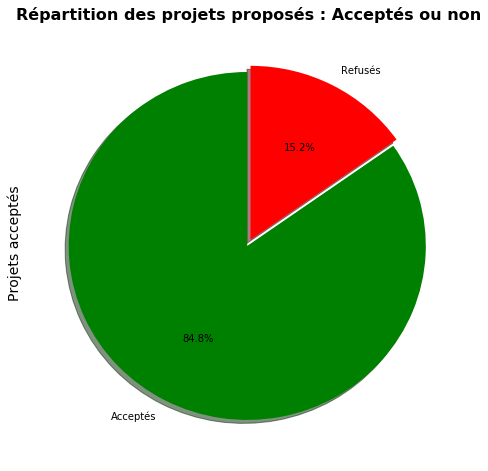

In [90]:
plt.figure(figsize=(8,8))
labels='Acceptés','Refusés'
colors = [c_app, c_nonapp]
explode = (0.02, 0.02)

train_dfN['project_is_approved'].value_counts().plot.pie(explode = explode, colors = colors, labels=labels, shadow=True, startangle=90 , autopct='%1.1f%%')
plt.title('Répartition des projets proposés : Acceptés ou non', fontsize=16, fontweight="bold")
plt.ylabel('Projets acceptés', fontsize=14)
plt.show()

Ce diagramme circulaire nous permet de voir que la majorité des projets sont acceptés et on peut en déduire qu'un projet à  environ 85% de chances d'être approuvé. <br>
Nos données ne sont pas équilibrées;<br>
Il faudra donc être particulièrement vigileants lors de la séparation de nos données en bases de validation/test pour lancer nos algorithmes d'apprentissage.

### 7.2. Etude du taux d'approbation des projets

In [91]:
df_approuved = train_dfN[train_dfN['project_is_approved']==1]
df_not_approuved = train_dfN[train_dfN['project_is_approved']==0]

#### 7.2.1. Evolution du taux d'approbation dans le temps

Nous présentons ici la manière dont le nombre de propositions approuvées et non approuvées évolue avec le temps, ainsi que le changement dans la fraction des projets approuvés dans le graphique du bas.

In [92]:
nbr_projets_approuves_date = df_approuved.groupby(['date'])['project_is_approved'].count()
nbr_projets_non_approuves_date = df_not_approuved.groupby(['date'])['project_is_approved'].count()

In [93]:
nbr_projets_total_date = df.groupby(['date'])['project_is_approved'].count()

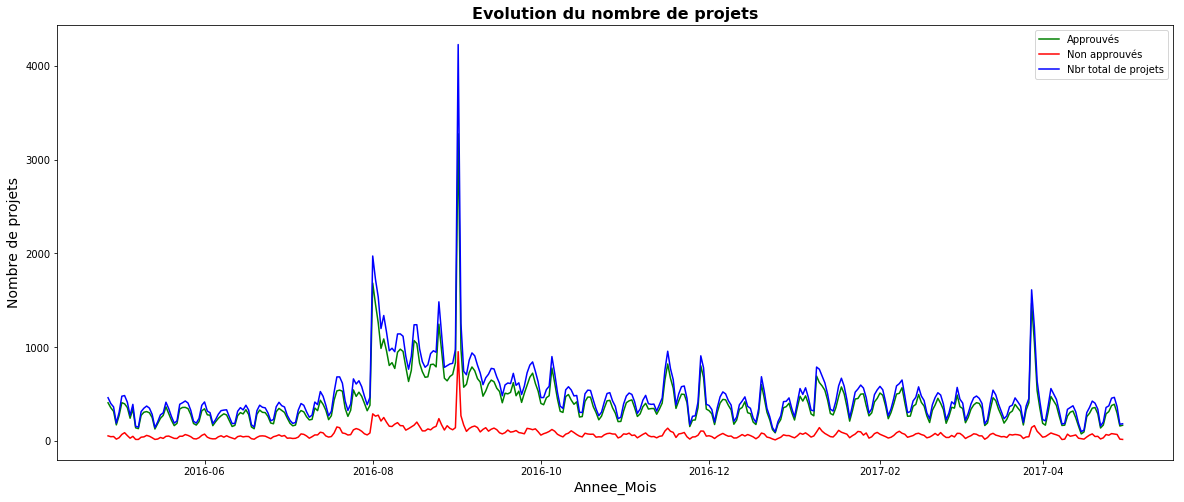

In [94]:
plt.figure(figsize=(20,8))

p1 = plt.plot(nbr_projets_approuves_date, c_app)
p2 = plt.plot(nbr_projets_non_approuves_date, c_nonapp)
p3 = plt.plot(nbr_projets_total_date, "blue")

plt.title('Evolution du nombre de projets', fontsize=16, fontweight="bold")
plt.xlabel('Annee_Mois', fontsize=14)
plt.ylabel('Nombre de projets', fontsize=14)
plt.legend((p1[0], p2[0], p3[0]), ('Approuvés', 'Non approuvés', 'Nbr total de projets'))
plt.show()

On remarque que le nombre de projets approuvés et non approuvés ont globalement les même fluctuations et les même evolutions.<br>
Le nombre de projets approuvés est toujours supérieur au nombre de projets non approuvés et correspondant pratiquement au nombre total de projets soumis (ce qui rejoint la constatation précédente -> voir section 7.1).<br>

In [95]:
nbr_projets_approuves_month = df_approuved.groupby(['month'])['project_is_approved'].count()
nbr_projets_non_approuves_month = df_not_approuved.groupby(['month'])['project_is_approved'].count()

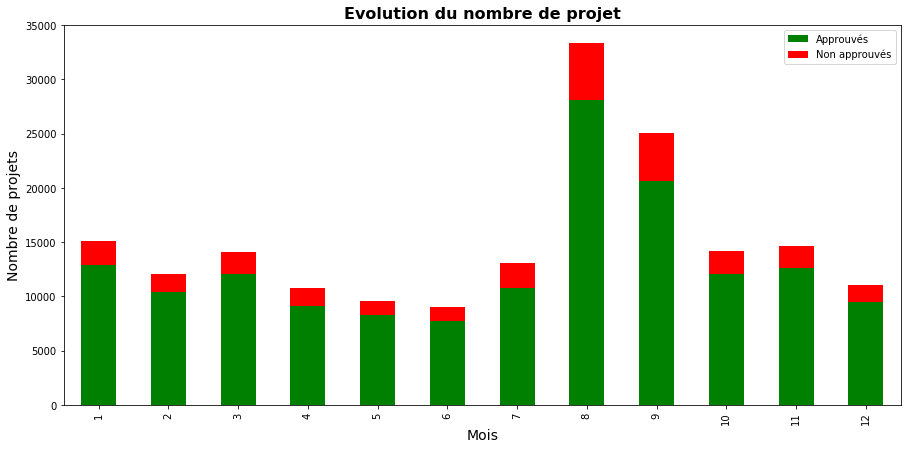

In [96]:
plt.figure(figsize=(15,7))
p1 = nbr_projets_approuves_month.plot.bar(color= c_app)
p2 = nbr_projets_non_approuves_month.plot.bar(color= c_nonapp, bottom = nbr_projets_approuves_month)

plt.title('Evolution du nombre de projet', fontsize=16, fontweight="bold")
plt.xlabel('Mois', fontsize=14)
plt.ylabel('Nombre de projets', fontsize=14)
plt.legend(['Approuvés', 'Non approuvés'])
plt.show()

In [97]:
nbr_projets_approuves_weekday = df_approuved.groupby(['weekday'])['project_is_approved'].count()
nbr_projets_non_approuves_weekday = df_not_approuved.groupby(['weekday'])['project_is_approved'].count()

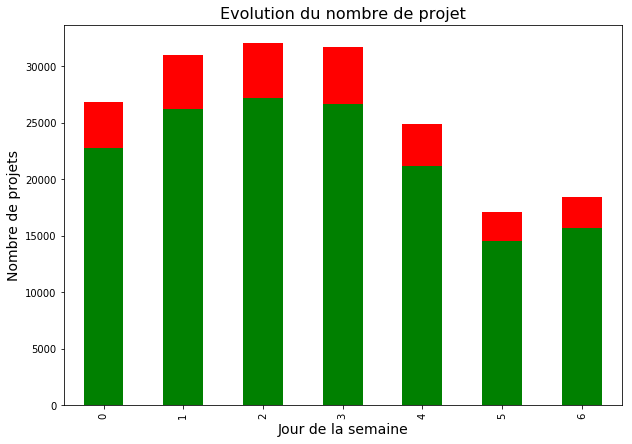

In [98]:
plt.figure(figsize=(10,7))
p1 = nbr_projets_approuves_weekday.plot.bar(color= c_app)
p2 = nbr_projets_non_approuves_weekday.plot.bar(color= c_nonapp, bottom = nbr_projets_approuves_weekday)

plt.title('Evolution du nombre de projet', fontsize=16)
plt.xlabel('Jour de la semaine', fontsize=14)
plt.ylabel('Nombre de projets', fontsize=14)
plt.show()

On remarque que le taux d'admission des projets (rapport projets approouvés/projets non approuvés) est plus elevé en weekend, les jours étant numéroté de (0-Lundi au 6-Dimanche).

#### 7.2.2. Etude du taux d'approbation en fonction de la distribution géographique

In [99]:
nbr_projets_approuves_etat = df_approuved.groupby(['school_state'])['project_is_approved'].count()
nbr_projets_non_approuves_etat = df_not_approuved.groupby(['school_state'])['project_is_approved'].count()

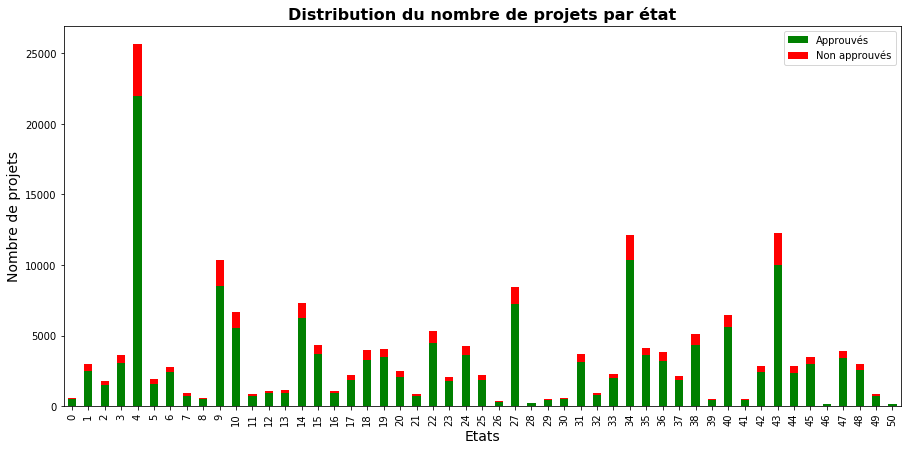

In [100]:
plt.figure(figsize=(15,7))
p1 = nbr_projets_approuves_etat.plot.bar(color= c_app)
p2 = nbr_projets_non_approuves_etat.plot.bar(color= c_nonapp, bottom = nbr_projets_approuves_etat)

plt.title('Distribution du nombre de projets par état', fontsize=16, fontweight="bold")
plt.xlabel('Etats', fontsize=14)
plt.ylabel('Nombre de projets', fontsize=14)
plt.legend(['Approuvés', 'Non approuvés'])
plt.show()

On remarque que le nombre de projets approuvés est proportionnel au nombre total de projets : si ce nombre augmente, alors le nombre de projets approuvés augmente et inversement.

#### 7.2.3. Prefixe des professeurs

In [101]:
nbr_projets_approuves_pref = df_approuved.groupby(['teacher_prefix'])['project_is_approved'].count()
nbr_projets_non_approuves_pref = df_not_approuved.groupby(['teacher_prefix'])['project_is_approved'].count()

In [102]:
pd.crosstab(train_dfN.teacher_prefix, train_dfN.project_is_approved, dropna=False, normalize='index')

project_is_approved,0.0,1.0
teacher_prefix,,
0,0.192308,0.807692
1,0.157978,0.842022
2,0.145915,0.854085
3,0.156948,0.843052
4,0.205777,0.794223
5,0.000000,1.000000


le nombre de 'Dr' est tellement faible qu'on n'arrive pas, à l'affichage du graphique, à voir les proportions de projets approuvés ou non. <br>
Comme precedemment, on remarque que le nombre de projets approuvés est proportionnel au nombre total de projets : si ce nombre augmente, alors le nombre de projets approuvés augmente et inversement.

In [103]:
nbr_projets_approuves_gender = df_approuved.groupby(['gender'])['project_is_approved'].count()
nbr_projets_non_approuves_gender = df_not_approuved.groupby(['gender'])['project_is_approved'].count()

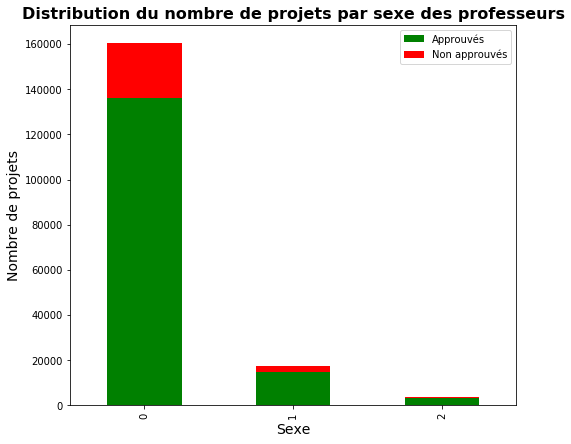

In [104]:
plt.figure(figsize=(8,7))
nbr_projets_approuves_gender.plot.bar(color= c_app)
nbr_projets_non_approuves_gender.plot.bar(color= c_nonapp, bottom = nbr_projets_approuves_gender)

plt.title('Distribution du nombre de projets par sexe des professeurs', fontsize=16, fontweight="bold")
plt.xlabel('Sexe', fontsize=14)
plt.ylabel('Nombre de projets', fontsize=14)
plt.legend(['Approuvés', 'Non approuvés'])
plt.show()

Ces résultats ne sont pas étonnants car il y a plus de femmes professeurs que d'hommes.

### 7.3. Etude du prix des projets

#### 7.3.1. Prix des projets par classes

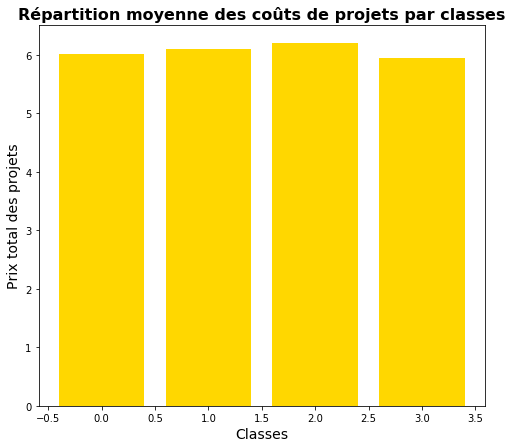

In [105]:
plt.figure(figsize=(8,7))
x=train_dfN.groupby(['project_grade_category'])['total_cost'].mean().index.values
y=train_dfN.groupby(['project_grade_category'])['total_cost'].mean().values

plt.bar(x, y, color='gold')
plt.title('Répartition moyenne des coûts de projets par classes', fontsize=16, fontweight="bold")
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Prix total des projets', fontsize=14)
plt.show()

On remarque que c'est pour les classes d'éléves les plus jeunes que nous avons les projets les plus couteux en moyenne (les projets pour les classes de 9eme-12eme années sont les projets en moyenne plus couteux) <br>
Les prix diminues de plus en plus pour les classes plus jeunes. 

#### 7.3.2. Evolution du prix des projets par classes par années

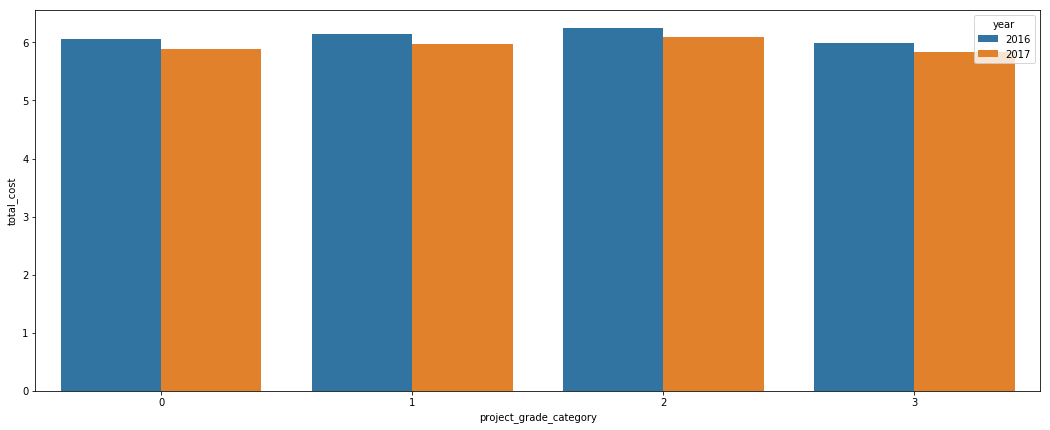

In [106]:
tmp_df = train_dfN.groupby(['project_grade_category','year'])['total_cost'].mean().reset_index()

plt.figure(figsize=(18,7))
sns.barplot(x='project_grade_category',y='total_cost',hue='year',data=tmp_df)

On remarque que le prix moyen des projets ont diminué de 2016 à 2017

#### 7.3.3. Prix des projets par catégories 

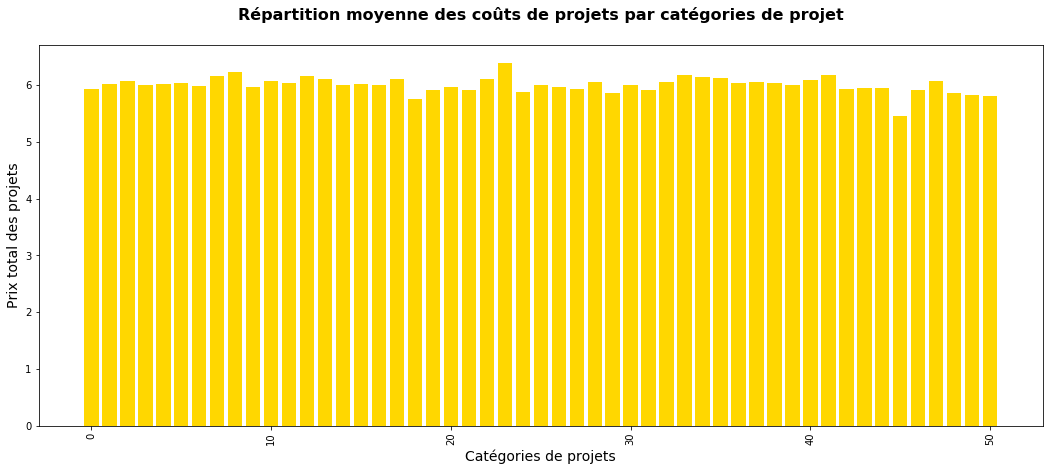

In [107]:
plt.figure(figsize=(18,7))
x=train_dfN.groupby(['project_subject_categories'])['total_cost'].mean().index.values
y=train_dfN.groupby(['project_subject_categories'])['total_cost'].mean().values

plt.bar(x, y, color='gold')
plt.title('Répartition moyenne des coûts de projets par catégories de projet', fontsize=16, fontweight="bold", y=1.05)
plt.xlabel('Catégories de projets', fontsize=14)
plt.xticks(rotation='vertical')
plt.ylabel('Prix total des projets', fontsize=14)
plt.show()

### 8. Apprentissage - Partie Machine Learning

Nous sommes enfin arrivé à la dérniére étape de notre compétition. Ici, nous allons lancer des algorithmes d'apprentissage sur la table que nous avons préparée.

Nous allons d'abord, lancer un Light Gradient Boosting (LightGBM)

boosting_type : Permet de spécifier le type de boosting<br>
objective : Classification binaire<br>
metric : la mesure qu'on va utiliser (la courbe roc)<br>
max_depth : Taille maximum des arbres<br>
num_leaves : Nombre de feuille que l'on aura dans les arbres<br>
learning_rate : Taux d'apprentissage (on minimise une certaine erreur avec le gradient et le learning_rate c'est le pas du gradient)<br>
feature_fraction : Pourcentage de features à utiliser<br>
bagging_fraction : pourcentage de données utilisées<br>
bagging_freq : Nombre d'estimateurs pour itération du bagging<br>
verbose : c'est juste pour l'affichage, on le met à 1 pour afficher les résultats à chaque itération<br>
num_threads : Nombre de workers<br>
lambda_l2 : Permet de faire une régularisation de type L2<br>
min_gain_to_split : Le seuil minimum de gain pour effectuer la séparation dans l'arbre<br>
seed : Un paramétre à renseigner pour réaliser le Random<br>

***

La fonction <b>train_test_split</b> permet de prendre les données avec la classe et de séparer l'echantillon en enssemble d'apprentissage et de validation

In [108]:
X_train_lgbm, X_valid_lgbm, y_train_lgbm, y_valid_lgbm = train_test_split(final_df_train, df_y_train, test_size=0.33, random_state=2018)

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 16,
        'num_leaves': 31,
        'learning_rate': 0.25,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'verbose': 1,
        'num_threads': 4,
        'lambda_l2': 1,
        'min_gain_to_split': 0,
        'seed':1234
} 

On lance le model
early_stopping_rounds : si le model ne s'améliore pas au bout de 100 round on l'arréte<br>
num_boost_round : nombre d'itération du boosting<br>
verbose_eval : fait un affichage chaque 25 itération<br>

In [109]:
model = lgb.train(
        params,
        lgb.Dataset(X_train_lgbm, y_train_lgbm),
        num_boost_round=10000,
        valid_sets=[lgb.Dataset(X_valid_lgbm, y_valid_lgbm)],
        early_stopping_rounds=100,
        verbose_eval=25)

Training until validation scores don't improve for 100 rounds.
[25]	valid_0's auc: 0.7709
[50]	valid_0's auc: 0.777419
[75]	valid_0's auc: 0.778726
[100]	valid_0's auc: 0.777815
[125]	valid_0's auc: 0.77723
[150]	valid_0's auc: 0.776769
[175]	valid_0's auc: 0.776596
Early stopping, best iteration is:
[77]	valid_0's auc: 0.778815


Nous allons à présent calculer le score de l'LGBM à partir de la surface sous la courbe de ROC.

In [110]:
valid_preds = model.predict(X_valid_lgbm, num_iteration=model.best_iteration)
test_preds = model.predict(final_df_test, num_iteration=model.best_iteration)
auc = roc_auc_score(y_valid_lgbm, valid_preds)
print('AUC:',auc)
plt.show()

AUC: 0.7788145410217806


Nous allons à présent lancer un Xgboost.

eta :  taux d'apprentissage<br>
max_depth : la profondeur de l'arbre<br>
subsample : à chaque fois on prend 80% des variables<br>
objective : la fonction objective utilise une regression logistique<br>
eval_metric : la mesure d'evaluation<br>
seed : initialisation pour le Random<br>

In [111]:
xgb_params = {'eta': 0.2, 
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 1234
                 }

X_train_xgb, X_valid_xgb, y_train_xgb, y_valid_xgb = train_test_split(final_df_train, df_y_train, test_size=0.33, random_state=2018)


d_train_xgb = xgb.DMatrix(X_train_xgb, y_train_xgb)
d_valid_xgb = xgb.DMatrix(X_valid_xgb, y_valid_xgb)
d_test_xgb = xgb.DMatrix(final_df_test)

Watchlist : permet de préciser la performance sur le train et sur la validation.
Puis on va lancer une prédiction.

In [112]:
watchlist = [(d_train_xgb, 'train'), (d_valid_xgb, 'valid')]
model_xgb = xgb.train(xgb_params, d_train_xgb, 500, watchlist, verbose_eval=50, early_stopping_rounds=20)

[0]	train-auc:0.708957	valid-auc:0.702774
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[50]	train-auc:0.815832	valid-auc:0.767505
[100]	train-auc:0.847119	valid-auc:0.774184
[150]	train-auc:0.867999	valid-auc:0.775679
[200]	train-auc:0.883903	valid-auc:0.777155
Stopping. Best iteration:
[213]	train-auc:0.888372	valid-auc:0.77748



Nous allons à présent calculer le score de l'XGB à partir de la surface sous la courbe de ROC.

In [113]:
xgb_pred_test = model_xgb.predict(d_test_xgb)
xgb_pred_valid = model_xgb.predict(d_valid_xgb)
auc = roc_auc_score(y_valid_xgb, xgb_pred_valid)
print('AUC:',auc)

AUC: 0.777129405663751


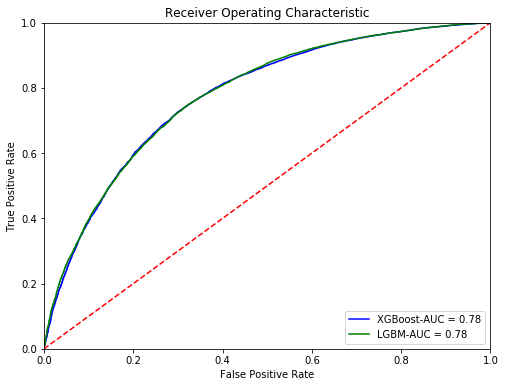

In [114]:
fpr,tpr,thresholds=roc_curve(y_valid_lgbm, xgb_pred_valid)
roc_auc = metrics.auc(fpr, tpr)

fpr_1,tpr_1,thresholds_1=roc_curve(y_valid_xgb, valid_preds)
roc_auc_1 = metrics.auc(fpr_1, tpr_1)

plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'XGBoost-AUC = %0.2f' % roc_auc)
plt.plot(fpr_1, tpr_1, 'g', label = 'LGBM-AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

La valeur de la courbe de ROc est de 0.78